In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analytics-ue20cs312/sample_submission.csv
/kaggle/input/data-analytics-ue20cs312/train.csv
/kaggle/input/data-analytics-ue20cs312/test.csv


In [2]:
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

In [3]:
data=pd.read_csv("/kaggle/input/data-analytics-ue20cs312/train.csv",parse_dates=['Date'], index_col='Date')
test=pd.read_csv("/kaggle/input/data-analytics-ue20cs312/test.csv")
data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-25,2412.25,2429.44,2387.41,2402.95,29106300
2022-07-26,2289.29,2307.08,2255.66,2280.27,48503400
2022-07-27,2309.14,2404.25,2296.82,2395.54,43790900
2022-07-28,2385.58,2443.26,2377.34,2434.89,25807000
2022-07-29,2410.86,2479.24,2406.35,2474.93,32907600


 **We checked for any NaN or null values in the dataset**

In [4]:
data.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

**Next we plot the line graph for the variables close and volume**

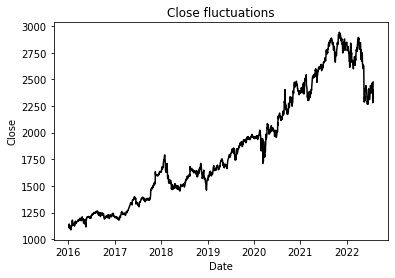

In [5]:
plt.plot(data["Close"], color = "Black")

plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Close fluctuations")

plt.show()

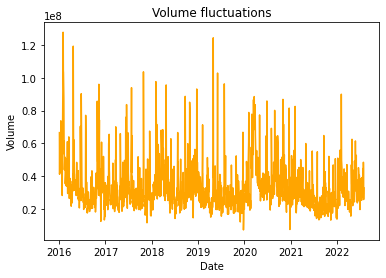

In [6]:
plt.plot(data["Volume"], color = "Orange")

plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume fluctuations")

plt.show()

**Now let's decompose our data into a multiplicative and additive series**

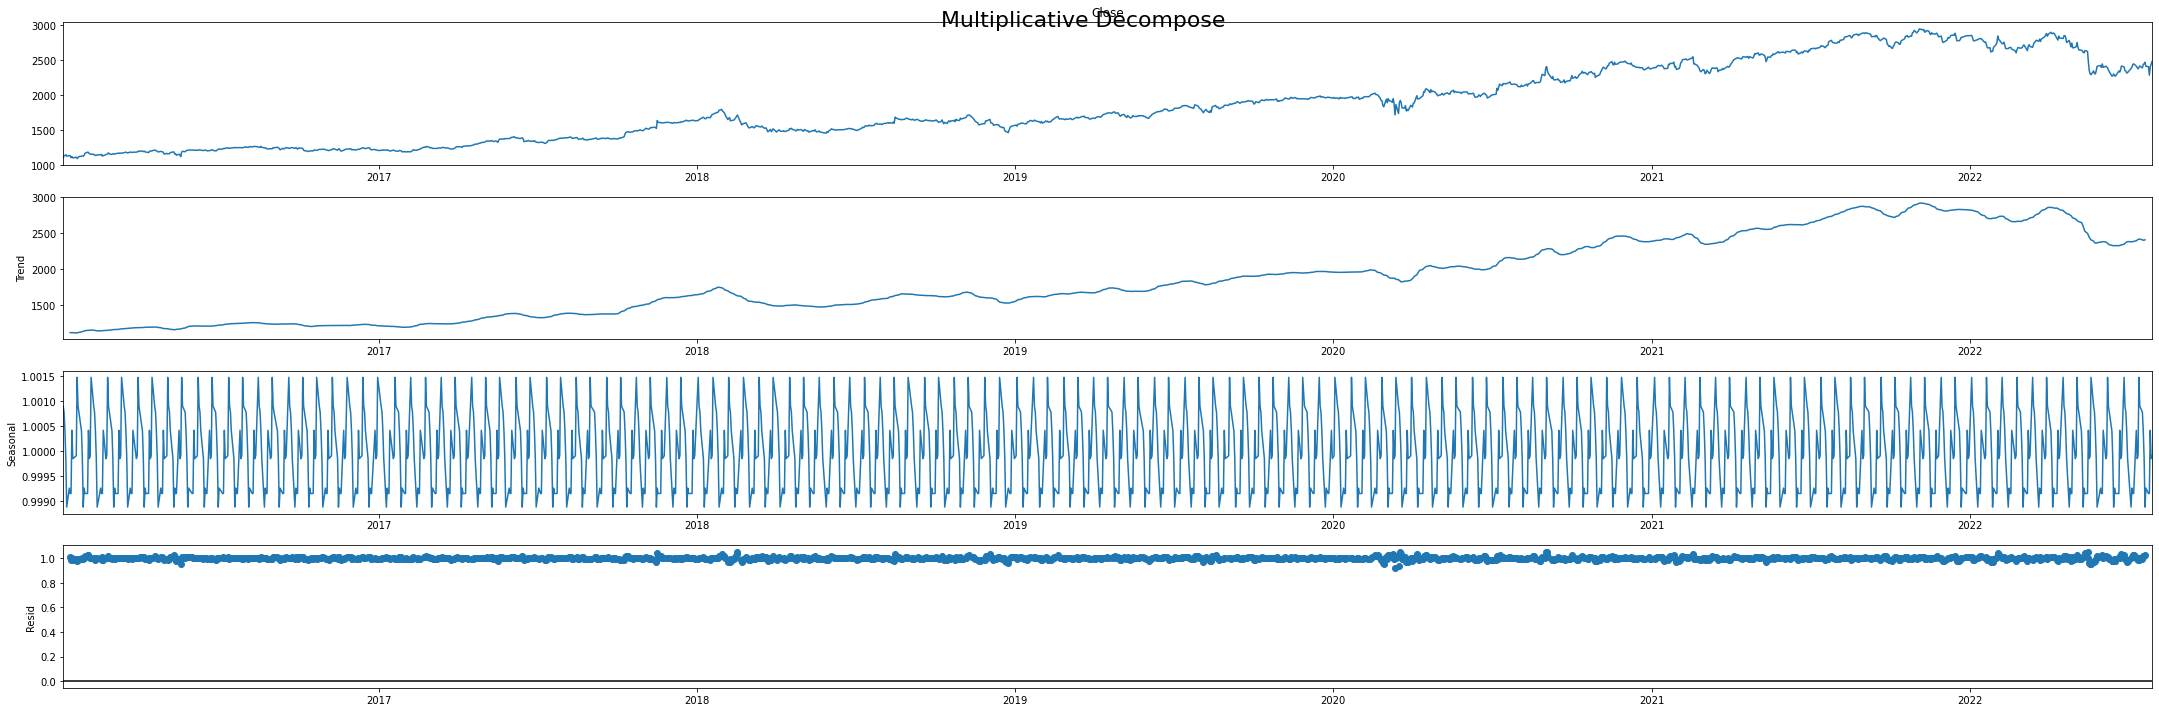

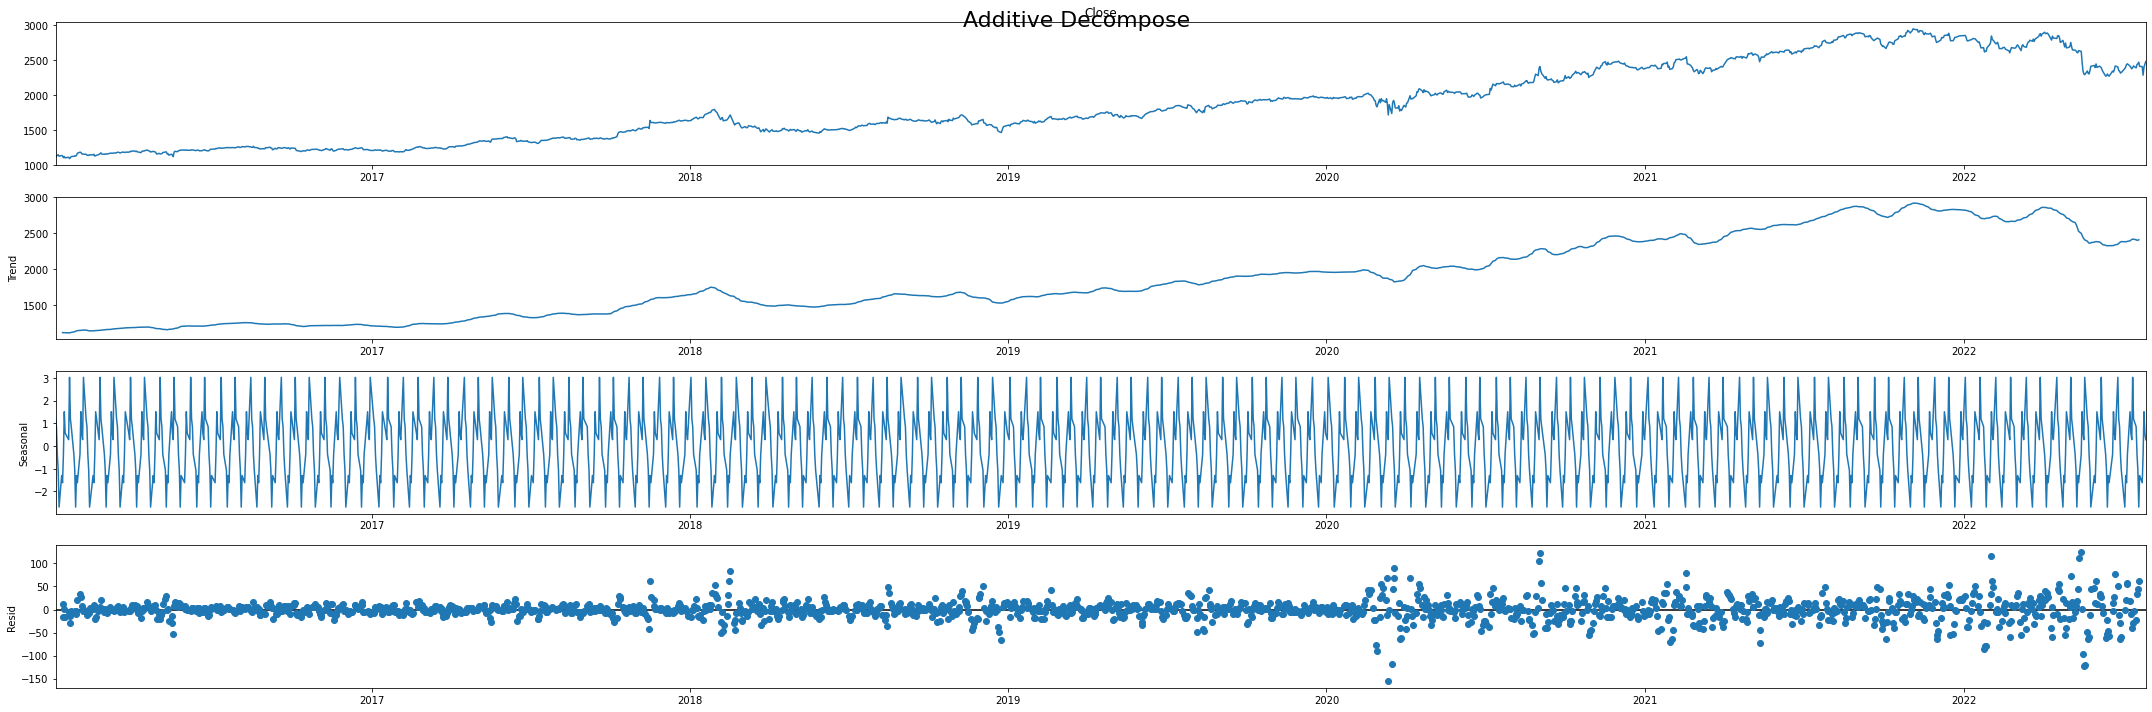

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

close_mul = seasonal_decompose(data["Close"], model='multiplicative',period = 12)

# Additive Decomposition
close_add = seasonal_decompose(data["Close"], model='additive',period = 12)

# Plot
plt.rcParams.update({'figure.figsize': (30,10)})
close_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
close_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

**We see that the close data follows an upward trend and has a seasonal component. 
It is multiplicative in nature**

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.Close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.961490
p-value: 0.767050


**In the above cell we are checking for stationarity using augmented dickey fuller test. The null hypothesis of the test is that the data is non-stationary.The alternate hypothesis is that the data is stationary.We are considering significance value as 0.05.We reject the null hypothesis if the p-value is less than 0.05.**

**P-value turns out to be 0.767 which is greater than the significance value so we do not reject null hypothesis and the data is non-stationary.**

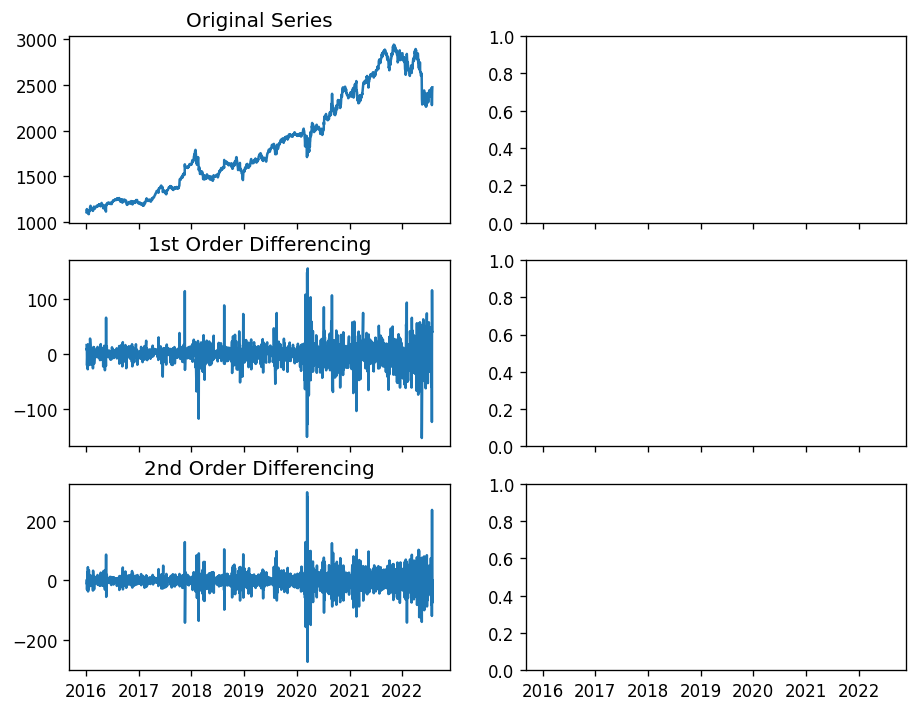

In [9]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.Close);
axes[0, 0].set_title('Original Series')


# 1st Differencing
axes[1, 0].plot(data.Close.diff()); 
axes[1, 0].set_title('1st Order Differencing')


# 2nd Differencing
axes[2, 0].plot(data.Close.diff().diff());
axes[2, 0].set_title('2nd Order Differencing')


plt.show()

**Let us plot the graph and check for stationarity,we see that it isn't stationary.We differentiate the data once and we found that the data is stationary and hence we can stop differentiating.**

In [10]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result_close = adfuller(data.Close.diff().dropna())
print('ADF Statistic: %f' % result_close[0])
print('p-value: %f' % result_close[1])

ADF Statistic: -13.875891
p-value: 0.000000


**In the above cell we are checking for stationarity using augmented dickey fuller test. 
The null hypothesis of the test is that the data is non-stationary.
The alternate hypothesis is that the data is stationary.
We are considering significance value as 0.05. We reject the null hypothesis.**

In [11]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00


**Let's import the arima model and run the auto_arima function to get the arima model.
The auto_arima returns the model with appropriate (p,d,q) values.**

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

arima_model = auto_arima(data.Close, start_p=0, start_q=0)

arima_model_fit = arima_model.fit(data.Close)
print(arima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1655
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -7481.082
Date:                Sun, 16 Oct 2022   AIC                          14968.164
Time:                        13:51:36   BIC                          14984.397
Sample:                             0   HQIC                         14974.182
                               - 1655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8791      0.563      1.561      0.119      -0.225       1.983
ar.L1         -0.0784      0.010     -7.520      0.000      -0.099      -0.058
sigma2       496.9468      7.412     67.046      0.0

**We see that the values of AIC and BIC are really high in this model due to which we can assume that the model won't be accurate.**

In [13]:
prediction_auto_arima = pd.DataFrame(arima_model.predict(n_periods = test["Open"].shape[0]))

prediction_auto_arima.columns = ['prediction_close']
prediction_auto_arima

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,prediction_close
1655,2472.669505
1656,2473.725817
1657,2474.522055
1658,2475.338686
1659,2476.153719
1660,2476.968876
1661,2477.784024
1662,2478.599172
1663,2479.414321
1664,2480.229469


**The above cell gives the predicated values of the auto_arima model (1,1,0).**

In [14]:
numcrunch_submission = pd.DataFrame({'Date':test.Date,'Close':prediction_auto_arima['prediction_close']})
numcrunch_submission.to_csv('submission.csv',index = False,date_format = "%Y%M%S")

In [15]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(data['Close'])).fit(smoothing_level = 0.3,smoothing_trend = 0.1)

In [16]:
prediction_holt_exp = pd.DataFrame(fit1.forecast(len(test)))

prediction_holt_exp.columns = ['prediction_close']
prediction_holt_exp

,prediction_close
0,2426.485331
1,2429.221047
2,2431.956763
3,2434.692480
4,2437.428196
5,2440.163912
6,2442.899628
7,2445.635344
8,2448.371060
9,2451.106776


<AxesSubplot:>

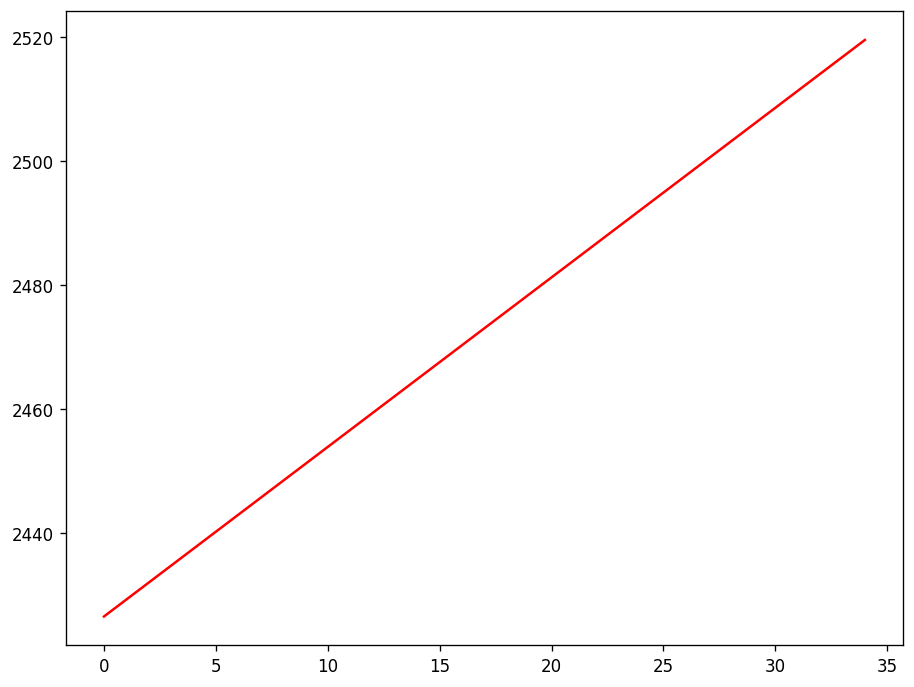

In [17]:
ax = plt.gca() 
prediction_holt_exp["prediction_close"].plot(kind = 'line',
        x = 'time',
        y = 'value',
        color = 'red',ax = ax)

**Upon predicting the predicted values of the model , we get a straight line with an upward trend hence we conclude that the model isn't performing well.**

In [18]:
numcrunch_submission = pd.DataFrame({'Date':test.Date,'Close':prediction_holt_exp['prediction_close']})
numcrunch_submission.to_csv('submission.csv',index = False,date_format = "%Y%M%S")

In [19]:
import statsmodels.api as sm
Smodel=sm.tsa.statespace.SARIMAX(data['Close'],order=(1, 1, 2),seasonal_order=(1,1,1,12))
resultS = Smodel.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63168D+00    |proj g|=  6.98496D-02

At iterate    5    f=  4.57997D+00    |proj g|=  1.42618D-02

At iterate   10    f=  4.50642D+00    |proj g|=  1.71793D-02

At iterate   15    f=  4.50611D+00    |proj g|=  4.06319D-04

At iterate   20    f=  4.50609D+00    |proj g|=  1.35125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   5.030D-06   4.506D+00
  F =   4.5060879176077240     

CONVERG

In the above cell, We tried to fit a SARIMA model by manually tuning the values (p,d,q).

In [20]:
prediction_Smodel = pd.DataFrame(resultS.predict(start = 1655,end = 1689))

prediction_Smodel.columns = ['prediction_close']
prediction_Smodel


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,prediction_close
1655,2476.193485
1656,2477.129846
1657,2476.444714
1658,2477.496329
1659,2477.936461
1660,2477.646824
1661,2478.159741
1662,2478.398443
1663,2476.091282
1664,2482.668496


<AxesSubplot:>

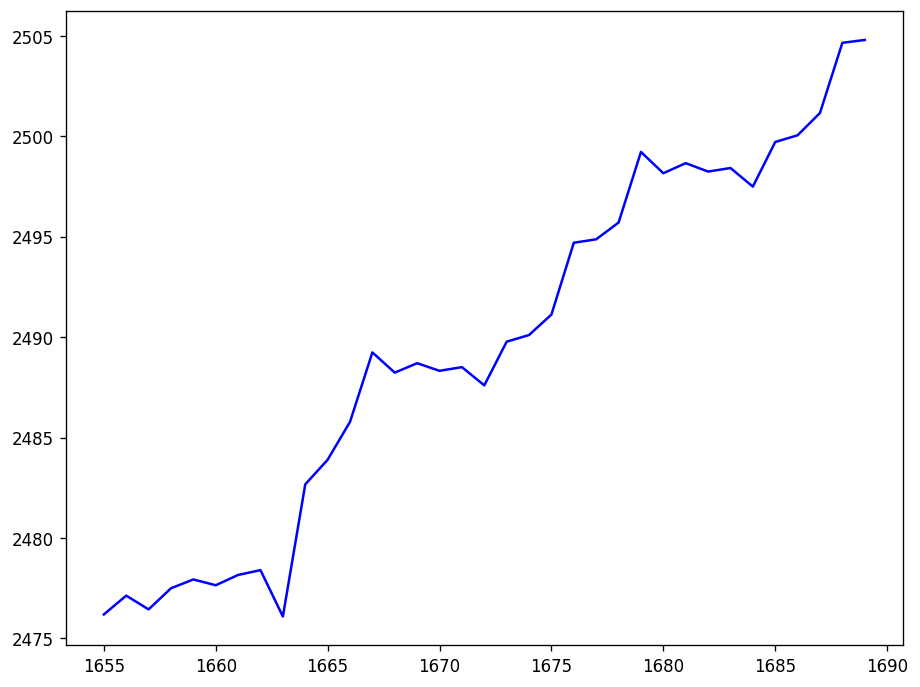

In [21]:
ax = plt.gca() 
prediction_Smodel["prediction_close"].plot(kind = 'line',
        x = 'time',
        y = 'value',
        color = 'blue',ax = ax)

**The manually tuned SARIMA model displays an upward trend in the predicted values.**

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [23]:
data1=pd.read_csv("/kaggle/input/data-analytics-ue20cs312/train.csv")
test1=pd.read_csv("/kaggle/input/data-analytics-ue20cs312/test.csv")

In [24]:
shape=data1.shape
print("Dataset contains {} rows and {} columns".format(shape[0],shape[1]))

Dataset contains 1655 rows and 6 columns


In [25]:
data1.head()

,Date,Open,High,Low,Close,Volume
0,2016-01-04,1099.59,1110.75,1093.85,1109.64,66545000
1,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
3,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
4,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900


In [26]:
data1 = data1.loc[:,['Date','Open','High','Low','Volume','Close']]
data1.head()

,Date,Open,High,Low,Volume,Close
0,2016-01-04,1099.59,1110.75,1093.85,66545000,1109.64
1,2016-01-05,1117.47,1130.57,1112.75,41227200,1125.85
2,2016-01-06,1116.63,1138.68,1116.10,42316800,1133.04
3,2016-01-07,1122.00,1149.76,1117.56,64899600,1143.37
4,2016-01-08,1145.64,1149.96,1120.93,52138900,1122.88


In [27]:
X_train = data1.iloc[:,1:5]
y_train = data1.iloc[:,5]

**Let's try to fit a MLR model, we take close as the dependent variable and the other features as the independent variables.**

In [28]:
linreg=LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression()

In [29]:
X_test = test1.iloc[:,1:5]

In [30]:
y_pred=linreg.predict(X_test)
y_pred

array([2485.54736286, 2473.79713315, 2481.06370484, 2437.91176866,
       2434.0979842 , 2459.61023538, 2440.52013793, 2483.31025528,
       2479.37166745, 2520.6168203 , 2535.46147291, 2601.47026751,
       2610.44407476, 2582.62518042, 2539.1894966 , 2492.83753483,
       2482.30313303, 2483.97032581, 2514.85572448, 2447.04922701,
       2436.55911464, 2415.19715209, 2422.84290302, 2442.93317432,
       2422.91399482, 2391.01482519, 2451.4505561 , 2454.04517209,
       2482.33942814, 2490.64324387, 2424.83022567, 2408.85167559,
       2386.26976777, 2374.00937757, 2386.26994579])

In [31]:
prediction_mlr = pd.DataFrame(y_pred)

prediction_mlr.columns = ['prediction_close']
prediction_mlr

,prediction_close
0,2485.547363
1,2473.797133
2,2481.063705
3,2437.911769
4,2434.097984
5,2459.610235
6,2440.520138
7,2483.310255
8,2479.371667
9,2520.616820


**The below graph shows the predicted values of close by MLR model.**

<AxesSubplot:>

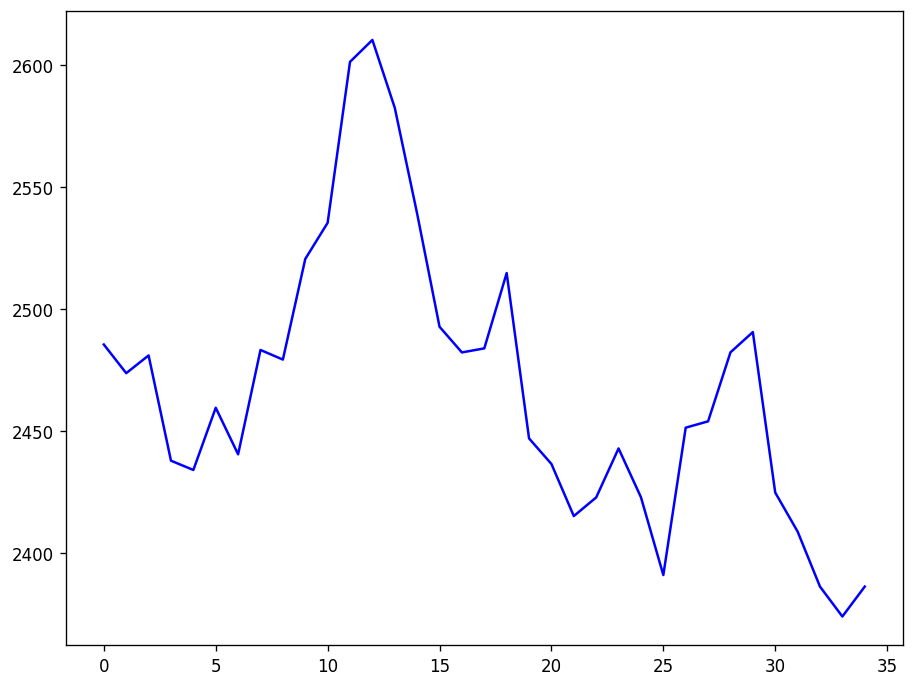

In [32]:
ax = plt.gca() 
prediction_mlr["prediction_close"].plot(kind = 'line',
        x = 'time',
        y = 'value',
        color = 'blue',ax = ax)

**Let's plot the values of open. If the graph of the predicted values turns out to be similar to the graph of open values, we can say that the model is predicting the values to a good extent.**

<AxesSubplot:>

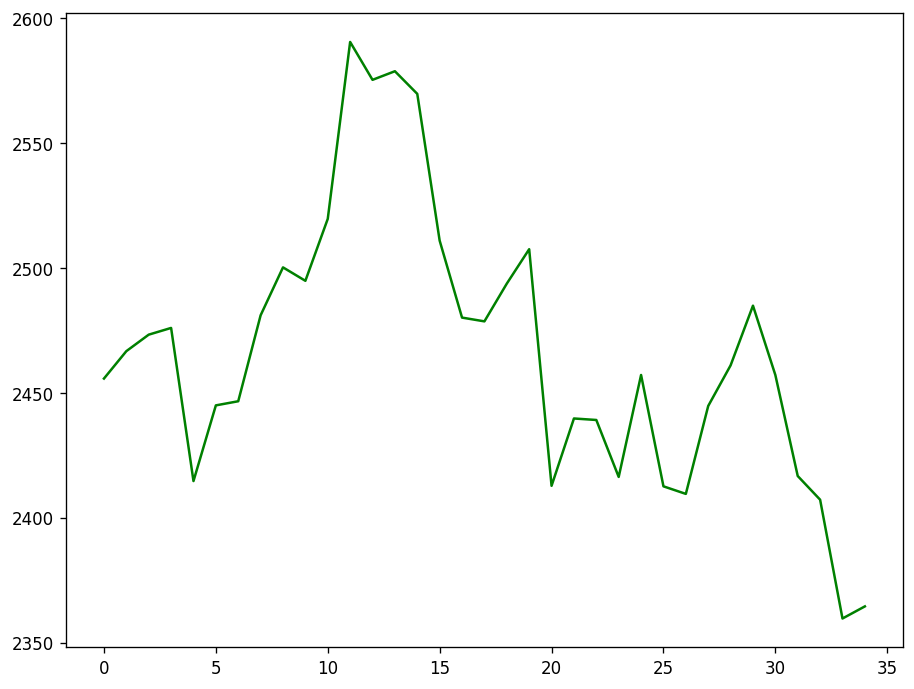

In [33]:
ax = plt.gca() 
test1["Open"].plot(kind = 'line',
        x = 'time',
        y = 'value',
        color = 'green',ax = ax)

In [34]:
numcrunch_submission_mlr = pd.DataFrame({'Date':test1.Date,'Close':prediction_mlr['prediction_close']})
numcrunch_submission_mlr.to_csv('submission.csv',index = False,date_format = "%Y%M%S")